In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [6]:
path = Path('../shrek')

# Download images

In [5]:
# select categories and select path
shrek_types = 'shrek dragon','shrek donkey','shrek', "lord farquaad", "puss in boots"

In [5]:
if not path.exists():
    path.mkdir()
    for o in shrek_types:
        dest = (path/o)
        print(dest)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o}', max_images=75)
        download_images(dest, urls=results)

## Control for errors

In [6]:
fns = get_image_files(path)
fns

(#323) [Path('fastbook/shrek/lord farquaad/0533e2e0-3652-42e1-a562-87f98e8dc0ba.png'),Path('fastbook/shrek/lord farquaad/057c09f7-03b4-45c8-af49-7db033281b4c.png'),Path('fastbook/shrek/lord farquaad/0837cc81-a795-4565-b9df-e0dd7ff54acb.jpg'),Path('fastbook/shrek/lord farquaad/08fca23c-7864-42c1-a9a7-30480d73fb6a.jpg'),Path('fastbook/shrek/lord farquaad/0a9774c2-b3d7-466b-b3eb-bd0ca1990d9c.jpg'),Path('fastbook/shrek/lord farquaad/0dc3f7df-5736-4c2d-aa8c-ea14226a294c.jpg'),Path('fastbook/shrek/lord farquaad/182b0adc-587b-4a05-b7e2-819af8850f22.jpeg'),Path('fastbook/shrek/lord farquaad/1b668247-ebcc-44ff-9940-002c18796ec2.jpg'),Path('fastbook/shrek/lord farquaad/2125a854-89a6-460c-8ece-62a68c79d567.png'),Path('fastbook/shrek/lord farquaad/2762b7d0-9569-42c4-84bc-a96a4c93a4ee.jpg')...]

In [7]:
failed = verify_images(fns)
failed

(#0) []

In [8]:
failed.map(Path.unlink);

# From data  to dataloaders

In [9]:
shrek_characters = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [20]:
shrek_characters = shrek_characters.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = shrek_characters.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


# Training

In [21]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.447399,2.496384,0.661290,00:37


epoch,train_loss,valid_loss,error_rate,time
0,1.389712,1.199267,0.387097,00:35
1,0.937302,0.545329,0.209677,00:38
2,0.745084,0.358214,0.096774,00:36
3,0.600150,0.275276,0.080645,00:34


## analyses and cleaning

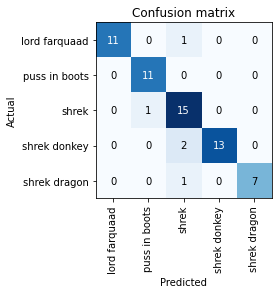

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

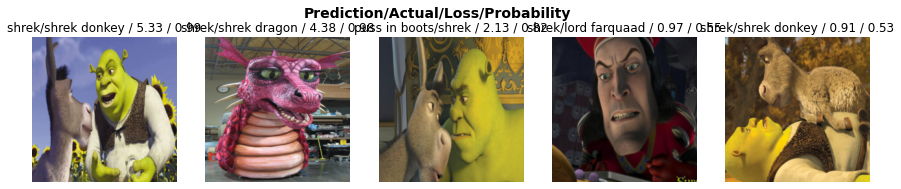

In [23]:
interp.plot_top_losses(5, nrows=1)

## Cleaning

In [14]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

### Potential deleting
Run the training again after deleting some of the files

In [19]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

# Saving the model

In [25]:
learn.export()

# Loading the model and using it for inference

In [3]:
learn = load_learner('export.pkl')

In [8]:
pred,pred_idx,probs = learn.predict(path/'download.jpg')

In [9]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: shrek; Probability: 0.9843')

## with widgets

In [10]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
img = PILImage.create(btn_upload.data[-1])